<a href="https://colab.research.google.com/github/Davidospina1000/Data-Integration/blob/main/Parcial_2_Integraci%C3%B3n_de_Datos_y_Prospectiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integración de Datos - Lógica Borrosa

De acuerdo con la base de datos Perdida de Productividad en Cultivos de Palma, llevar a cabo el siguiente procedimiento:

Para la base de Datos Observados, llevar a cabo un proceso de gestión de las pérdidas para cuatro (4) niveles de gestión, de acuerdo con la matriz de impacto definida en el curso: 1:1,1:2,1:3,1:4. Es importante para las distribuciones de pérdida que arrojan estas gestiones, hacer una análisis de las variables de los diferentes indicadores que arroja función describe(), así como el coeficiente de asimetría, y el Opeartional Value at Risk (OpVar) o pérdida extrema. Es importante mencionar, que estos indicadores muestran la prospectiva del riesgo frente a la implementación de diferentes matrices de gestión, con el fin de mitigar las pérdidas asociadas con las operaciones agrícolas.
Tomando como base de referencia los Datos Observados, llevar a cabo la integración de los datos para cada una de las cuatro (4) fincas que posee la base de datos (Finca 1, Finca 2, Finca 3, Finca 4). Para esta integración se sugiere un nivel de integración del 99%. Es importante analizar los datos y las variaciones para las métricas que arroja función describe() en python. Es importante analizar igualmente, las variaciones experimentadas por los coeficientes de Asimetría y el OpVar para antes y despues de la integración de los datos.

## I. Gestión e Impacto

0. Se cargan las librerías de trabajo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

1. Se definen las funciones de trabajo

In [64]:
NC = 5  # Número de cualidades
lbf = ['Muy Pocos', 'Pocos', 'Más o Menos', 'Muchos', 'Bastantes']
lbs = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']

def clusterizar_variable(X, n_clusters):
    modelo = KMeans(n_clusters=n_clusters, init='random', random_state=42)
    modelo.fit(X.reshape(-1, 1))
    centros = np.sort(modelo.cluster_centers_.flatten())
    sigma = np.array([np.sum(np.abs(centros - c)) / 4 for c in centros]).reshape(-1, 1)
    return centros, sigma

def calcular_pertenencia(valor, centros, sigma):
    return np.exp(-0.5 * ((centros - valor) / sigma) ** 2)

def crear_matriz_impacto():
    return np.array([[1, 1, 1, 2, 2],
                     [1, 2, 2, 3, 3],
                     [1, 2, 3, 3, 4],
                     [2, 3, 3, 4, 4],
                     [2, 3, 4, 4, 5]])

def graficar_heatmap(matriz, titulo, xlabels, ylabels):
    plt.figure()
    sns.heatmap(matriz, annot=True, cmap='jet', fmt='.2f')
    plt.title(titulo)
    plt.xlabel('Severidad (MUSD)')
    plt.ylabel('Frecuencia (Mes)')
    plt.xticks(np.arange(len(xlabels)) + 0.5, xlabels, rotation=90)
    plt.yticks(np.arange(len(ylabels)) + 0.5, ylabels, rotation=0)
    plt.tight_layout()
    plt.show()

def calcular_matriz_borrosa(xf, xs, XCf, XCs, sigmaf, sigmas):
    VPf = calcular_pertenencia(xf, XCf.reshape(5,1), sigmaf)
    VPs = calcular_pertenencia(xs, XCs.reshape(5,1), sigmas)
    MB = np.outer(VPf, VPs)
    return MB

def obtener_MT(MB):
    VMB = np.sort(MB.flatten())[::-1]
    MT = np.zeros(MB.shape)
    for i in range(4):
        MT[np.where(MB == VMB[i])] = 1
    return MT

def simular_escenario(XCf, XCs, sigmaf, sigmas, dff, dfs, MP, NG, MI_base):
    MG = MI_base.astype(float).copy()
    MG[(MG > 1) & (MG < 5)] *= NG
    XLDA, XLDAm = np.zeros((1000, 1)), np.zeros((1000, 1))

    for k in range(1000):
        xf = dff.sample(n=1).values[0][0]
        xs = dfs.sample(n=1).values[0][0]
        MB = calcular_matriz_borrosa(xf, xs, XCf, XCs, sigmaf, sigmas)
        MT = obtener_MT(MB)
        XLDA[k] = xf * xs
        XLDAm[k] = np.sum(MP * MB * MT * MI_base) / np.sum(MB * MT * MG)

    return XLDA.flatten(), XLDAm.flatten(), MG

def obtener_metricas(distrib):
    descr = pd.Series(distrib.flatten()).describe()
    op_var = np.percentile(distrib, 99.9)
    pne = (descr['mean'] + op_var) / 2
    asim = skew(distrib.flatten())
    df_metricas = pd.DataFrame({
        'count': [descr['count']],
        'mean': [descr['mean']],
        'std': [descr['std']],
        'min': [descr['min']],
        '25%': [descr['25%']],
        '50%': [descr['50%']],
        '75%': [descr['75%']],
        'max': [descr['max']],
        'OpVar (99.9%)': [op_var],
        'PNE': [pne],
        'Asimetría': [asim]
    })

    return df_metricas.round(2)

2. Carga y procesamiento de los datos

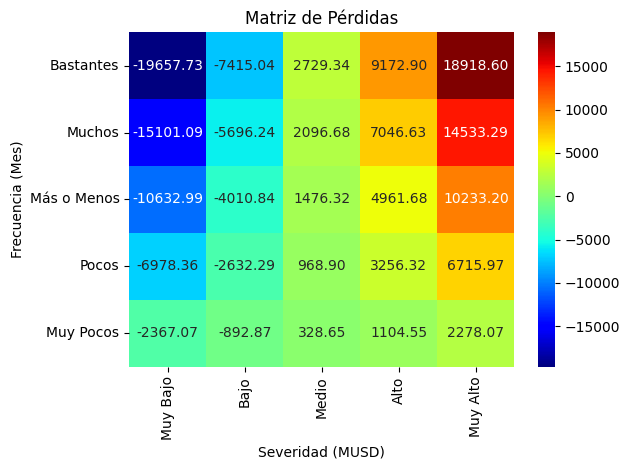

In [57]:
nxl = '/content/3. Perdida Productividad_Zonas(I).xlsx'
XDB = pd.read_excel(nxl, sheet_name=0)
XDB = np.array(XDB[['Frecuencia', 'Severidad']])
XDB[:, 1] /= 1000  # convertir severidad a millones (MUSD)

# Clusterización
XCf, sigmaf = clusterizar_variable(XDB[:, 0], NC)
XCs, sigmas = clusterizar_variable(XDB[:, 1], NC)

# Matriz de pérdidas
MP = np.outer(XCf, XCs)
MP_ordenada = MP[::-1, :]
lbf_ordenada = lbf[::-1]

# Visualización de la matriz de pérdidas
graficar_heatmap(MP_ordenada, 'Matriz de Pérdidas', lbs, lbf_ordenada)

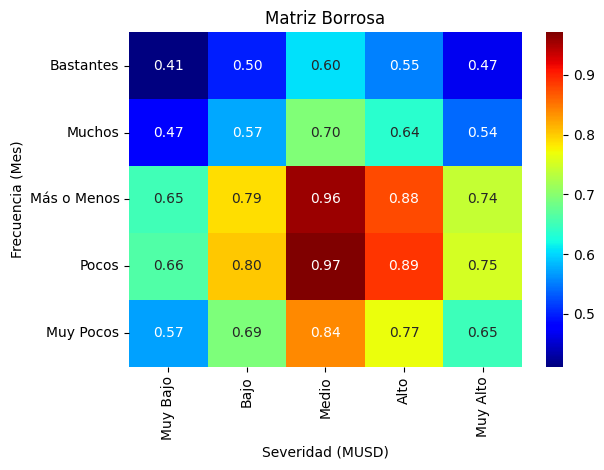

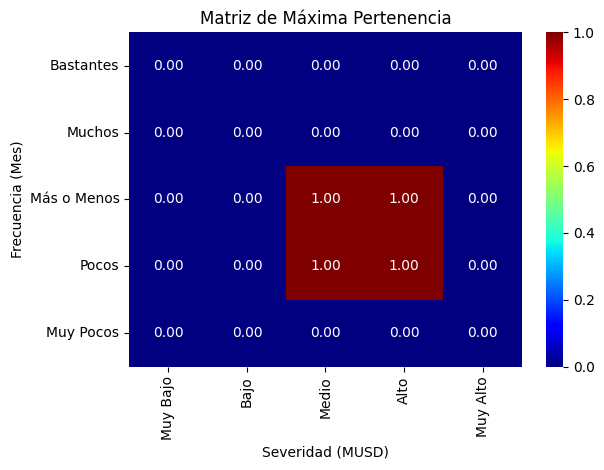

La pérdida matemática es: 1200
La pérdida borrosa es: 2597.9653390311973


In [58]:
# Evaluamos con un solo valor
Xf, Xs = 40, 30

MB = calcular_matriz_borrosa(Xf, Xs, XCf, XCs, sigmaf, sigmas)
MB_ordenada = MB[::-1, :]
graficar_heatmap(MB_ordenada, 'Matriz Borrosa', lbs, lbf_ordenada)

# Matriz de máxima pertenencia
MT = obtener_MT(MB)
MT_ordenada = MT[::-1, :]
graficar_heatmap(MT_ordenada, 'Matriz de Máxima Pertenencia', lbs, lbf_ordenada)

# Pérdida matemática vs. Pérdida borrosa
print("La pérdida matemática es:", Xf * Xs)
XLDAm_val = np.sum(MP * MB * MT) / np.sum(MB * MT)
print("La pérdida borrosa es:", XLDAm_val)


3. Comparación de escenarios de gestión (1:1, 1:2, 1:3 y 1:4)

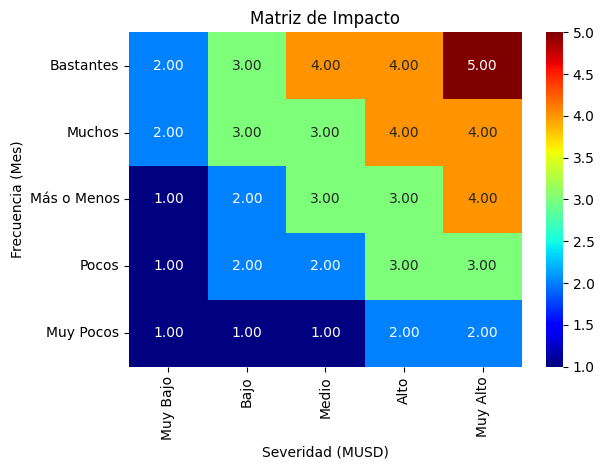

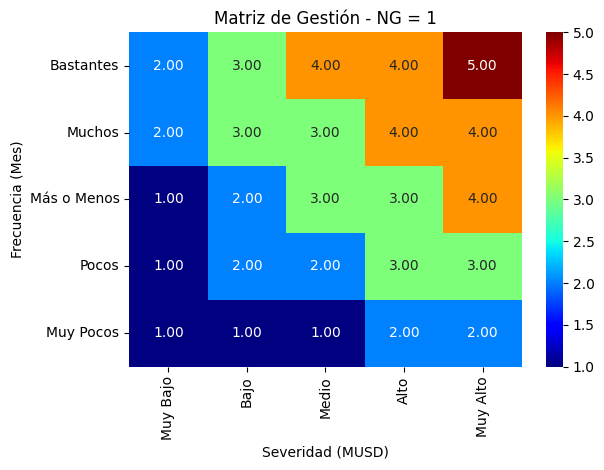

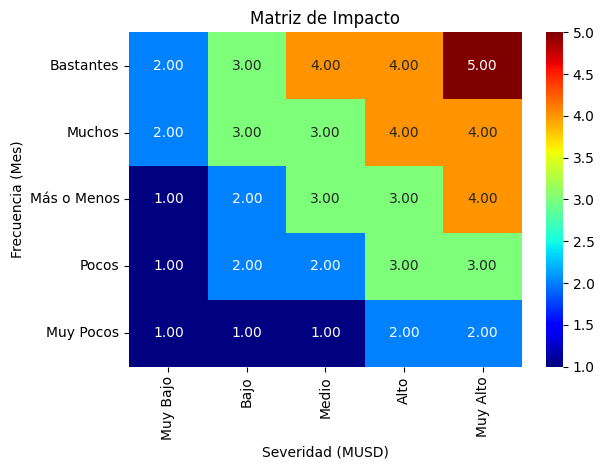

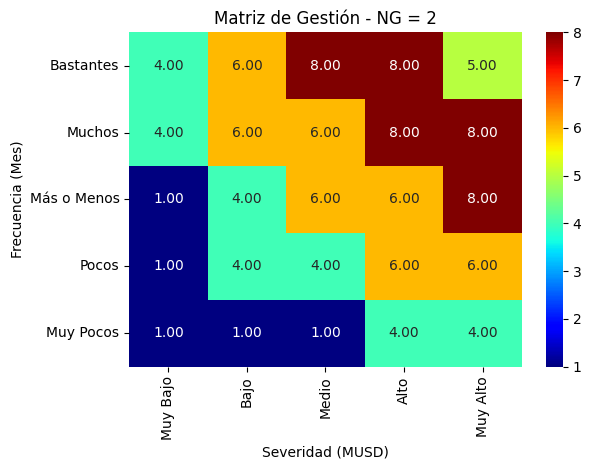

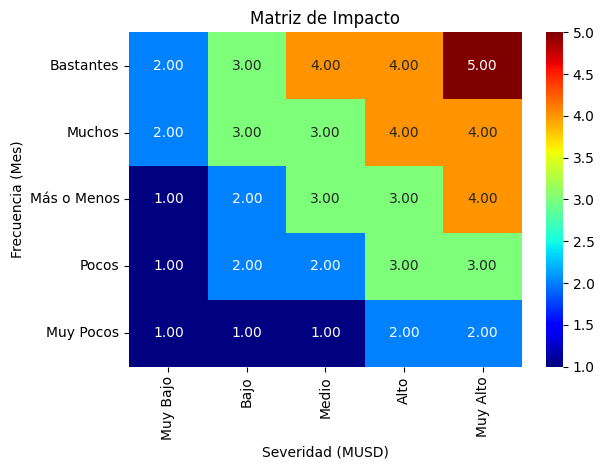

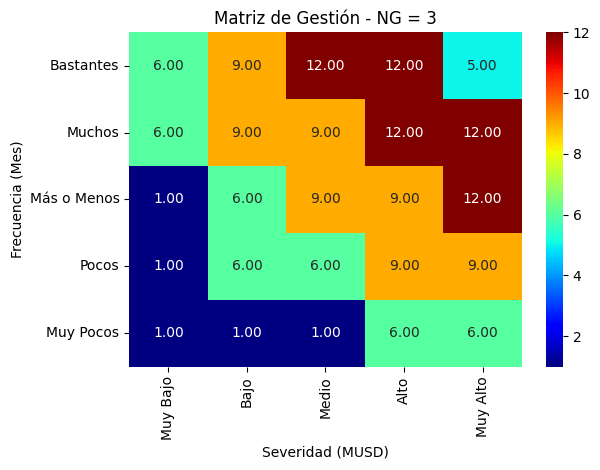

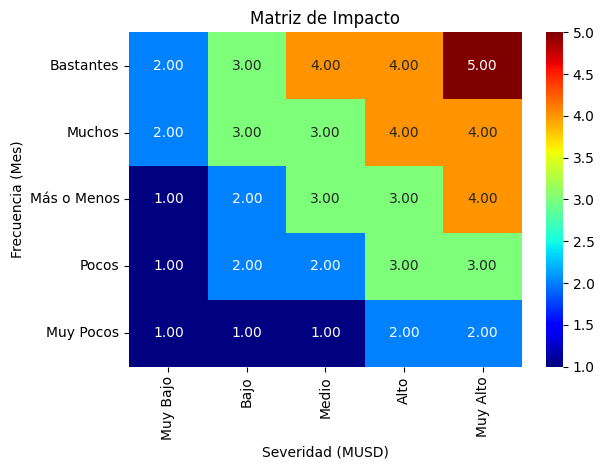

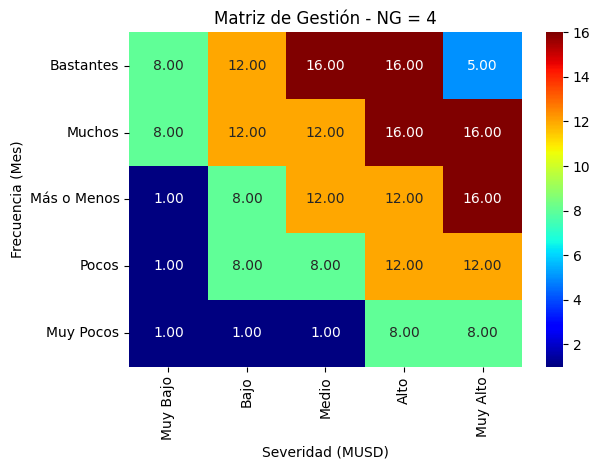

,NG,count,mean,std,min,25%,50%,75%,max,OpVar (99.9%),PNE,Asimetría
0,Original,1000.0,3216.54,5253.57,-24183.41,695.67,2527.37,5587.80,22816.83,22649.12,12932.83,-0.12
1,1,1000.0,4098.01,5021.84,-14235.93,1804.88,3603.15,6616.46,13992.59,13908.18,9003.10,-0.52
2,2,1000.0,2212.13,2688.19,-7157.41,949.22,1782.08,3349.78,8600.09,8572.55,5392.34,0.02
3,3,1000.0,1623.95,1815.96,-6142.93,651.09,1193.48,2552.72,6400.15,6206.42,3915.18,0.24
4,4,1000.0,1128.44,1575.46,-4871.84,490.79,882.98,1687.73,4953.71,4898.70,3013.57,-0.10


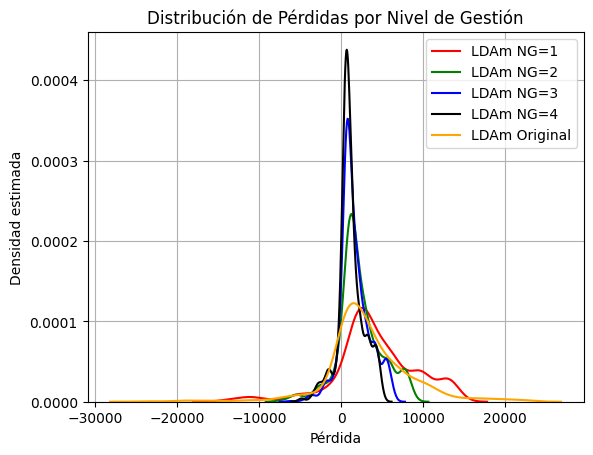

In [59]:
dff = pd.DataFrame(XDB[:, 0])
dfs = pd.DataFrame(XDB[:, 1])
MI = crear_matriz_impacto()
tabla_metricas = []

XLDA_all = {}
XLDAm_all = {}
colores = {1: 'red', 2: 'green', 3: 'blue', 4: 'black'}

# Escenario original
XLDA_original = dff.sample(1000, replace=True).values.flatten() * dfs.sample(1000, replace=True).values.flatten()
XLDAm_all["Original"] = XLDA_original.flatten()
metricas_original = obtener_metricas(XLDA_original.flatten())
metricas_original.insert(0, 'NG', 'Original')
tabla_metricas.append(metricas_original)

# Escenarios NG 1 a 4
for NG in [1, 2, 3, 4]:
    XLDA, XLDAm, MG = simular_escenario(XCf, XCs, sigmaf, sigmas, dff, dfs, MP, NG, MI)
    XLDA_all[NG] = XLDA
    XLDAm_all[NG] = XLDAm
    metricas = obtener_metricas(XLDAm_all[NG])
    metricas.insert(0, 'NG', NG)
    tabla_metricas.append(metricas)
    # Visualizar matriz de impacto
    graficar_heatmap(MI[::-1, :], 'Matriz de Impacto', lbs, lbf[::-1])
    # Visualizar matriz de gestión para NG actual
    graficar_heatmap(MG[::-1, :], f'Matriz de Gestión - NG = {NG}', lbs, lbf[::-1])


df_metricas = pd.concat(tabla_metricas, ignore_index=True)
display(df_metricas)

# Gráfica de distribuciones
plt.figure()
for NG in [1, 2, 3, 4]:
    sns.kdeplot(XLDAm_all[NG], label=f'LDAm NG={NG}', linestyle='-', color=colores[NG])
sns.kdeplot(XLDA_original, label='LDAm Original', linestyle='-', color='orange')
plt.title('Distribución de Pérdidas por Nivel de Gestión')
plt.xlabel('Pérdida')
plt.ylabel('Densidad estimada')
plt.legend()
plt.grid()
plt.show()

## Análisis de resultados

La implementación de matrices de gestión para mitigar los riesgos en los cultivos del sector palmero demuestra un impacto claro en la reducción del perfil de pérdidas, reafirmando la efectividad de estas estrategias. Al comparar el escenario sin gestión con los niveles de intervención del 1 al 4, se observa una disminución sistemática en las pérdidas esperadas (media), el valor en riesgo extremo (OpVar al 99.9%) y las pérdidas no esperadas (PNE), lo que evidencia un entorno cada vez más controlado y asegurable. Gráficamente, también es posible ver ante el aumento de los niveles de gestión, distribuciones cada vez más esbeltas.

En el escenario original, sin intervención, las pérdidas esperadas se sitúan en 3,216.54 MUSD, con un OpVar de 22,649.12 MUSD y una PNE de 12,932.83 MUSD. La asimetría negativa leve (-0.12) sugiere una ligera inclinación hacia eventos extremos por debajo de la media. Con la introducción de gestión nivel 1, la media aumenta a 4,098.01 MUSD debido al recorte de pérdidas negativas extremas, pero el OpVar se reduce a 13,908.18 MUSD y la PNE cae a 9,003.10 MUSD, mostrando una mejora sustancial en la contención del riesgo catastrófico.

A partir del nivel 2, el efecto de mitigación se vuelve aún más evidente. Las pérdidas esperadas disminuyen a 2,212.13 MUSD, el OpVar cae a 8,572.55 MUSD y la PNE se reduce a 5,392.34 MUSD. La asimetría cambia a ligeramente positiva (0.02), indicando una distribución más equilibrada. Esta tendencia se acentúa con los niveles 3 y 4, donde las pérdidas esperadas bajan a 1,623.95 y 1,128.44 MUSD respectivamente, mientras que el OpVar desciende a 6,206.42 y 4,898.70 MUSD. La PNE en el nivel 4 alcanza su mínimo con 3,013.57 MUSD, y la asimetría vuelve a ser ligeramente negativa (-0.10), reflejando una distribución más centrada y estable.


## II. Integración Borrosa

0. Se cargan los datos externos

In [60]:
nxl2 = '/content/3. Perdida Productividad_Zonas(I).xlsx'
XDBe1=pd.read_excel(nxl2,sheet_name=1); XDBe1=XDBe1.dropna()
XDBe2=pd.read_excel(nxl2,sheet_name=2); XDBe2=XDBe2.dropna()
XDBe3=pd.read_excel(nxl2,sheet_name=3); XDBe3=XDBe3.dropna()
XDBe4=pd.read_excel(nxl2,sheet_name=4); XDBe4=XDBe4.dropna()

XDBe1 = np.array(XDBe1[['Frecuencia', 'Severidad']])
XDBe1[:, 1] /= 1000  # convertir severidad a millones (MUSD)
XDBe2 = np.array(XDBe2[['Frecuencia', 'Severidad']])
XDBe2[:, 1] /= 1000  # convertir severidad a millones (MUSD)
XDBe3 = np.array(XDBe3[['Frecuencia', 'Severidad']])
XDBe3[:, 1] /= 1000  # convertir severidad a millones (MUSD)
XDBe4 = np.array(XDBe4[['Frecuencia', 'Severidad']])
XDBe4[:, 1] /= 1000  # convertir severidad a millones (MUSD)

Xfe1=np.array(XDBe1[:,0]); Xse1=np.array(XDBe1[:,1])
Xfe2=np.array(XDBe2[:,0]); Xse2=np.array(XDBe2[:,1])
Xfe3=np.array(XDBe3[:,0]); Xse3=np.array(XDBe3[:,1])
Xfe4=np.array(XDBe4[:,0]); Xse4=np.array(XDBe4[:,1])



1. Se definen las funciones para la integración borrosa

In [65]:
# Nombres de etiquetas
lbf = ['Muy pocos', 'Pocos', 'Más o Menos', 'Muchos', 'Bastantes']
lbs = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']

def mostrar_metricas(LDAo, LDAe, LDAint):
    mo = obtener_metricas(LDAo)
    me = obtener_metricas(LDAe)
    mint = obtener_metricas(LDAint)

    df_metricas = pd.concat([mo, me, mint], axis=0).reset_index(drop=True)
    df_metricas.index = ['Original', 'Externa', 'Integrada']

    # Cálculo del cambio porcentual respecto a la base original
    media_original = mo['mean'].values[0]
    asim_original = mo['Asimetría'].values[0]

    df_metricas['%Δ Media'] = ((df_metricas['mean'] - media_original) / media_original * 100).round(2)
    df_metricas['%Δ Asimetría'] = ((df_metricas['Asimetría'] - asim_original) / asim_original * 100).round(2)

    display(df_metricas)

# Función para procesar una sola base externa
def procesar_base_externa(XDBe, LDAo, XCf, XCs, sigmaf, sigmas):
    Xfe = XDBe[:, 0]
    Xse = XDBe[:, 1]

    # Mostrar primer registro de pertenencia
    VPf = calcular_pertenencia(Xfe[0], XCf.reshape(5,1), sigmaf)
    VPs = calcular_pertenencia(Xse[0], XCs.reshape(5,1), sigmas)

    dffe = pd.DataFrame(VPf.T)
    dffe.columns=np.array(lbf).reshape(5,1)
    dfse = pd.DataFrame(VPs.T)
    dfse.columns=np.array(lbs).reshape(5,1)
    print("Pertenencia primer registro (frecuencia):")
    display(dffe)
    print("Pertenencia primer registro (severidad):")
    display(dfse)

    # Evaluar todos los registros
    LDAe = []
    m1 = 0
    for k in range(len(Xfe)):
        VPf = calcular_pertenencia(Xfe[k], XCf.reshape(5,1), sigmaf)
        VPs = calcular_pertenencia(Xse[k], XCs.reshape(5,1), sigmas)
        VPmax = np.max(VPf) * np.max(VPs)

        if VPmax > 0.99:
            m1 += 1
            print("Se procede con la integración del registro:\n", k)
            LDAe.append(Xfe[k] * Xse[k])

    print("Número final de datos integrados:", m1)

    LDAe = np.array(LDAe).reshape(-1, 1)
    LDAo=LDAo.reshape(1000,1)
    LDAint = np.vstack((LDAo, LDAe))
    LDAe_full = (Xfe * Xse).reshape(-1, 1)

    # Gráficas
    plt.figure()
    sns.kdeplot(x=LDAo.flatten(), fill=True, color='red', label='LDAo')
    sns.kdeplot(x=LDAe_full.flatten(), fill=True, color='blue', label='LDAe')
    sns.kdeplot(x=LDAint.flatten(), fill=True, color='green', label='LDAint')
    plt.legend()
    plt.grid()
    plt.show()

    # Métricas
    mostrar_metricas(LDAo, LDAe_full, LDAint)

2. Se ejecuta la función para realizar la integración y obtener las métricas

Pertenencia primer registro (frecuencia):


,"(Muy pocos,)","(Pocos,)","(Más o Menos,)","(Muchos,)","(Bastantes,)"
0,0.329792,0.294419,0.478905,0.910155,0.992731


Pertenencia primer registro (severidad):


,"(Muy Bajo,)","(Bajo,)","(Medio,)","(Alto,)","(Muy Alto,)"
0,0.47745,0.516221,0.82213,0.989961,0.946134


Se procede con la integración del registro:
 2
Se procede con la integración del registro:
 6
Se procede con la integración del registro:
 13
Se procede con la integración del registro:
 14
Se procede con la integración del registro:
 15
Se procede con la integración del registro:
 22
Se procede con la integración del registro:
 24
Se procede con la integración del registro:
 26
Se procede con la integración del registro:
 27
Se procede con la integración del registro:
 28
Se procede con la integración del registro:
 34
Se procede con la integración del registro:
 42
Se procede con la integración del registro:
 44
Se procede con la integración del registro:
 45
Se procede con la integración del registro:
 48
Se procede con la integración del registro:
 49
Se procede con la integración del registro:
 52
Se procede con la integración del registro:
 54
Se procede con la integración del registro:
 69
Se procede con la integración del registro:
 74
Se procede con la integración del registro

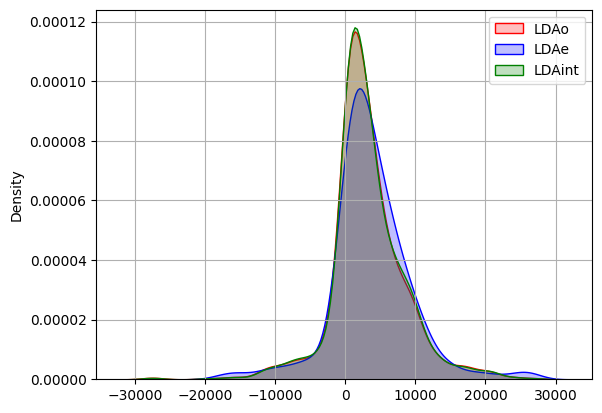

,count,mean,std,min,25%,50%,75%,max,OpVar (99.9%),PNE,Asimetría,%Δ Media,%Δ Asimetría
Original,1000.0,3142.19,5398.22,-28213.98,529.40,2475.44,5533.02,27369.03,25159.60,14150.89,0.05,0.00,0.0
Externa,235.0,3648.87,5724.71,-17513.41,772.23,2927.23,6046.48,26255.95,26204.58,14926.73,0.35,16.13,600.0
Integrada,1072.0,3190.24,5371.62,-28213.98,565.68,2475.44,5662.77,27369.03,25051.55,14120.89,0.06,1.53,20.0


Pertenencia primer registro (frecuencia):


,"(Muy pocos,)","(Pocos,)","(Más o Menos,)","(Muchos,)","(Bastantes,)"
0,0.37109,0.352744,0.560528,0.951,0.98


Pertenencia primer registro (severidad):


,"(Muy Bajo,)","(Bajo,)","(Medio,)","(Alto,)","(Muy Alto,)"
0,0.525062,0.592197,0.892766,0.999967,0.914187


Se procede con la integración del registro:
 4
Se procede con la integración del registro:
 13
Se procede con la integración del registro:
 16
Se procede con la integración del registro:
 22
Se procede con la integración del registro:
 27
Se procede con la integración del registro:
 31
Se procede con la integración del registro:
 34
Se procede con la integración del registro:
 36
Se procede con la integración del registro:
 42
Se procede con la integración del registro:
 46
Se procede con la integración del registro:
 48
Se procede con la integración del registro:
 52
Se procede con la integración del registro:
 59
Se procede con la integración del registro:
 60
Se procede con la integración del registro:
 63
Se procede con la integración del registro:
 66
Se procede con la integración del registro:
 68
Se procede con la integración del registro:
 71
Se procede con la integración del registro:
 72
Se procede con la integración del registro:
 73
Se procede con la integración del registr

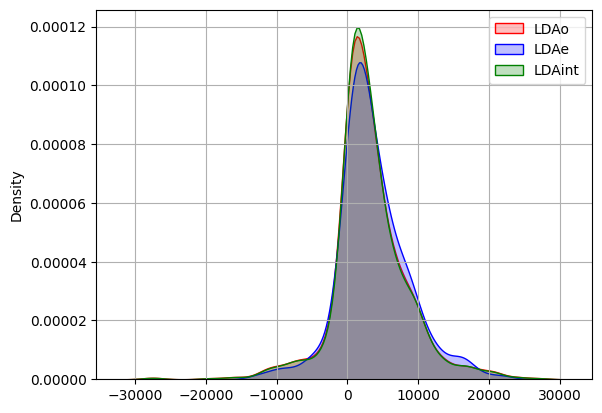

,count,mean,std,min,25%,50%,75%,max,OpVar (99.9%),PNE,Asimetría,%Δ Media,%Δ Asimetría
Original,1000.0,3142.19,5398.22,-28213.98,529.40,2475.44,5533.02,27369.03,25159.60,14150.89,0.05,0.00,0.0
Externa,235.0,3632.32,4906.54,-12617.29,965.65,2756.98,5916.43,22010.84,21389.30,12510.81,0.49,15.60,880.0
Integrada,1055.0,3142.67,5322.89,-28213.98,563.95,2484.46,5417.55,27369.03,25076.89,14109.78,0.06,0.02,20.0


Pertenencia primer registro (frecuencia):


,"(Muy pocos,)","(Pocos,)","(Más o Menos,)","(Muchos,)","(Bastantes,)"
0,0.992167,0.90393,0.552498,0.312824,0.34218


Pertenencia primer registro (severidad):


,"(Muy Bajo,)","(Bajo,)","(Medio,)","(Alto,)","(Muy Alto,)"
0,0.514923,0.576063,0.879019,0.999339,0.921464


Se procede con la integración del registro:
 0
Se procede con la integración del registro:
 11
Se procede con la integración del registro:
 16
Se procede con la integración del registro:
 20
Se procede con la integración del registro:
 27
Se procede con la integración del registro:
 30
Se procede con la integración del registro:
 32
Se procede con la integración del registro:
 42
Se procede con la integración del registro:
 44
Se procede con la integración del registro:
 46
Se procede con la integración del registro:
 49
Se procede con la integración del registro:
 59
Se procede con la integración del registro:
 61
Se procede con la integración del registro:
 63
Se procede con la integración del registro:
 68
Se procede con la integración del registro:
 71
Se procede con la integración del registro:
 78
Se procede con la integración del registro:
 81
Se procede con la integración del registro:
 83
Se procede con la integración del registro:
 89
Se procede con la integración del registr

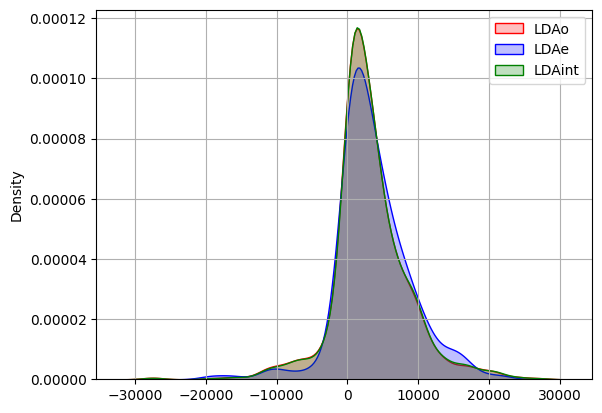

,count,mean,std,min,25%,50%,75%,max,OpVar (99.9%),PNE,Asimetría,%Δ Media,%Δ Asimetría
Original,1000.0,3142.19,5398.22,-28213.98,529.40,2475.44,5533.02,27369.03,25159.60,14150.89,0.05,0.00,0.0
Externa,235.0,3617.98,5209.70,-19176.31,724.54,2819.92,6120.55,21812.72,21209.81,12413.90,-0.06,15.14,-220.0
Integrada,1055.0,3213.95,5395.30,-28213.98,557.35,2502.21,5602.18,27369.03,25076.89,14145.42,0.09,2.28,80.0


Pertenencia primer registro (frecuencia):


,"(Muy pocos,)","(Pocos,)","(Más o Menos,)","(Muchos,)","(Bastantes,)"
0,0.989431,0.915807,0.573237,0.32694,0.352309


Pertenencia primer registro (severidad):


,"(Muy Bajo,)","(Bajo,)","(Medio,)","(Alto,)","(Muy Alto,)"
0,0.518915,0.58242,0.884518,0.999682,0.918628


Se procede con la integración del registro:
 1
Se procede con la integración del registro:
 2
Se procede con la integración del registro:
 4
Se procede con la integración del registro:
 5
Se procede con la integración del registro:
 6
Se procede con la integración del registro:
 8
Se procede con la integración del registro:
 14
Se procede con la integración del registro:
 16
Se procede con la integración del registro:
 22
Se procede con la integración del registro:
 24
Se procede con la integración del registro:
 27
Se procede con la integración del registro:
 35
Se procede con la integración del registro:
 42
Se procede con la integración del registro:
 44
Se procede con la integración del registro:
 46
Se procede con la integración del registro:
 47
Se procede con la integración del registro:
 48
Se procede con la integración del registro:
 49
Se procede con la integración del registro:
 54
Se procede con la integración del registro:
 57
Se procede con la integración del registro:
 6

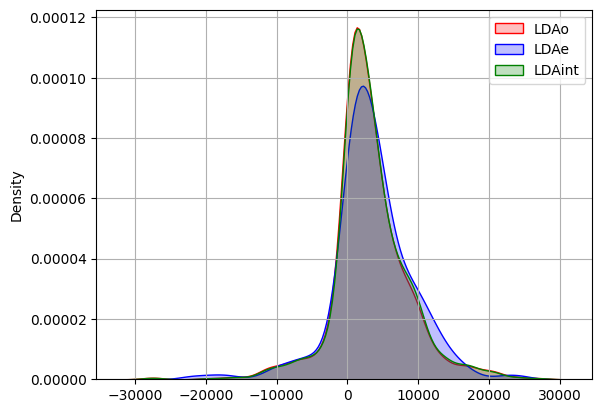

,count,mean,std,min,25%,50%,75%,max,OpVar (99.9%),PNE,Asimetría,%Δ Media,%Δ Asimetría
Original,1000.0,3142.19,5398.22,-28213.98,529.40,2475.44,5533.02,27369.03,25159.60,14150.89,0.05,0.00,0.0
Externa,235.0,3531.56,5660.34,-21905.03,774.91,3085.77,6190.59,24325.27,23784.29,13657.92,-0.37,12.39,-840.0
Integrada,1081.0,3262.59,5364.08,-28213.98,599.54,2558.25,5739.05,27369.03,25038.13,14150.36,0.05,3.83,0.0


In [66]:
dff=pd.DataFrame(XDB[:,0])
dfs=pd.DataFrame(XDB[:,1])
Xf=np.array(dff.sample(n=1000, replace=True))
Xs=np.array(dfs.sample(n=1000, replace=True))
LDAo=np.array(Xf*Xs).flatten()

XCf=XCf.reshape(5,1)
XCs=XCs.reshape(5,1)

procesar_base_externa(XDBe1, LDAo, XCf, XCs, sigmaf, sigmas)
procesar_base_externa(XDBe2, LDAo, XCf, XCs, sigmaf, sigmas)
procesar_base_externa(XDBe3, LDAo, XCf, XCs, sigmaf, sigmas)
procesar_base_externa(XDBe4, LDAo, XCf, XCs, sigmaf, sigmas)

## Análisis de resultados

### **Finca externa 1**

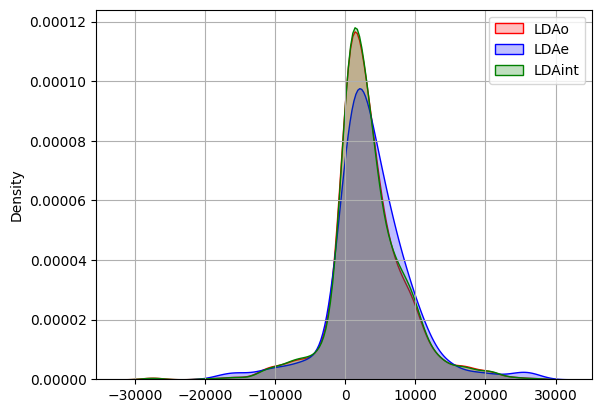

Para esta base de datos externa, el número final de datos integrados fueron 72. la integración de los datos externos a la distribución original (LDAint) produjo un efecto controlado sobre las estadísticas principales. La media aumentó apenas un 1.53%, lo que sugiere una leve alza en las pérdidas promedio esperadas. La asimetría también se incrementó, pero solo en un 20%, lo que indica una ligera intensificación en la cola derecha de la distribución, en contraste con el fuerte aumento del 600% observado al usar únicamente los datos externos. Además, el valor extremo (OpVar al 99.9%) se mantuvo prácticamente estable (de 25,159.60 a 25,051.55), lo cual evidencia que la integración de datos fue realizada de forma adecuada, conservando la estructura de riesgo original y suavizando el impacto de los datos externos más extremos


### **Finca Externa 2**

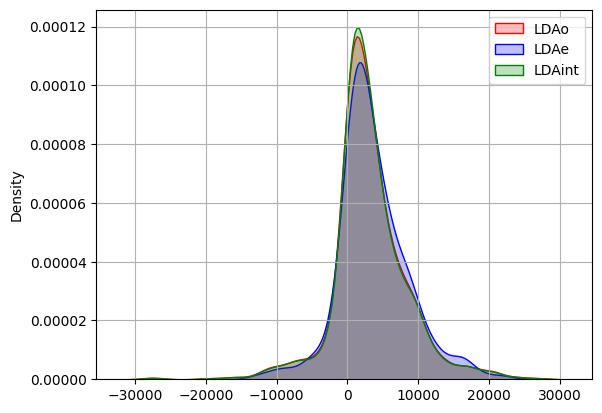

En el caso de la base de datos externa 3, se logró una integración de 55 datos frente a la base interna (LDAo).La incorporación de datos externos en este escenario resultó en un impacto casi imperceptible sobre la media, con un aumento relativo del 0.02%, lo que muestra que el valor promedio de pérdidas se mantuvo esencialmente sin cambios. En cuanto a la asimetría, se incrementó ligeramente en 20%, indicando una leve intensificación en la presencia de eventos extremos, aunque muy controlada en comparación con el fuerte sesgo introducido por los datos externos aislados (880%). La desviación estándar se redujo levemente respecto a la muestra original, lo que podría reflejar una menor dispersión relativa al integrar los nuevos datos. Por su parte, el OpVar se ajustó (de 25,159.60 a 25,076.89), confirmando que el perfil de riesgo extremo prácticamente no se alteró.

### **Finca Externa 3**

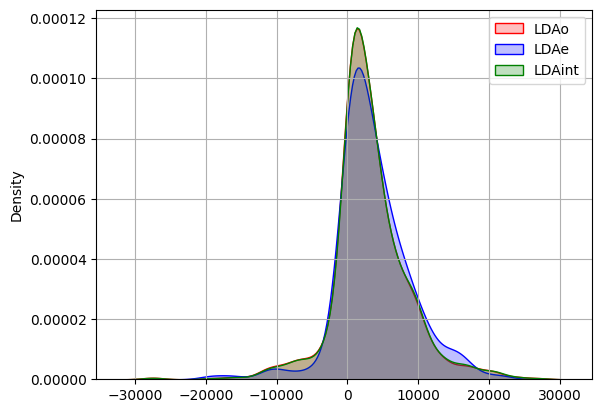

Para la base de datos externa 3, al implementar un nivel de integración del 99,9%, se logró la integración de 55 registros a la LDAo. En este caso, la combinación de datos externos con la muestra original generó cambios sutiles en las métricas estadísticas. El promedio de pérdidas creció un 2.28%, reflejando un ligero aumento en la expectativa de pérdida. En cuanto a la asimetría, se elevó en 80%, lo que indica que la distribución presenta una cola más pronunciada hacia valores extremos positivos (pero sigue siendo cercana al valor de la original), aunque este efecto es considerablemente menor que el sesgo negativo que podría haber al integrar todos los datos externos por sí solos (donde la asimetría se redujo en 220%). A pesar de estas variaciones, el valor en riesgo extremo (OpVar percentil 99.9%) apenas se modificó (de 25,159.60 a 25,076.89), lo que demuestra que la estructura del riesgo severo se mantuvo prácticamente intacta.

### **Finca Externa 4**

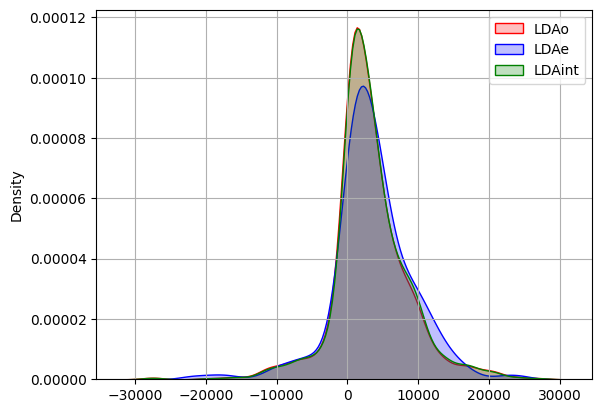

Para la última base de datos externa se evidencia un total de registros integrados de 81. La integración de datos externos produjo un aumento mínimo en la media del 3.83%, lo que indica una pequeña alza en el valor esperado de las pérdidas. No obstante, la asimetría se mantuvo inalterada respecto al valor original (0.05), lo cual sugiere que la forma de la distribución no se vio afectada. Aunque los datos externos por sí solos presentaban una asimetría menor (indicando una distribución menos sesgada) y una mayor dispersión, su integración no trasladó esas características de forma significativa al conjunto, lo cual demuestra un procedimiento efectivo al momento de obtener nuevos datos.